<a id='top'></a>
<img align="center" src="https://licard.ru/FileSystem/4/5958.png" width="100" />
<p style="text-align: center;">
    <font size='6' type='bold'>
        <b>Сегментирование клиентов по категориям</b>
    </font>
</p>

## Содержание

<a href='#section_0'>Постановка задачи</a>

<a href='#section_1'>Общая информация о данных</a>

<a href='#section_2'>Предобработка данных</a>

<a href='#section_3'>Исследование моделей</a>
* <a href='#section_3_1'>Решающее дерево</a>
* <a href='#section_3_2'>Случайный лес</a>
* <a href='#section_3_3'>Логистическая регрессия
* <a href='#section_3_4'>CatBoost

<a href='#section_4'>Предсказания на тестовой выборке</a>
    
<a href='#section_5'>Заключение</a>

<a id='section_0'></a>
## Постановка задачи
Стоит задача сегментировать клиентов по трем категориям (0,1,2). При этом необходимо разработать модель, предсказывающую к какому из трех сегментов относится каждый клиент.

Критерии оценивания
1.	Точность предсказания оцениваем по метрике macro_f_score
2.	Оценка кода: структура, последовательность действий, комментарии и выводы, чистота и понимание кода

In [2]:
# Импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

import time
import warnings
warnings.filterwarnings("ignore")
rnd_state = 260686


<a id='section_1'></a>
## Общая информация о данных

In [2]:
# Импортируем данные

data_test = pd.read_csv('contest_test.csv')
data_train = pd.read_csv('contest_train.csv')


In [3]:
# Выведем общую информацию о тестовой выборке

print('_/_/_/ Общая информация _/_/_/')
display(data_test.info())
print('_/_/_/ Пропущенные значения _/_/_/')
display(data_test.isna().sum().sort_values(ascending=False))
print('_/_/_/ Дубликаты _/_/_/')
display(data_test.duplicated().sum())
print('_/_/_/ Таблица _/_/_/')
display(data_test.head(3))


_/_/_/ Общая информация _/_/_/
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6131 entries, 0 to 6130
Columns: 261 entries, ID to FEATURE_259
dtypes: float64(260), int64(1)
memory usage: 12.2 MB


None

_/_/_/ Пропущенные значения _/_/_/


FEATURE_189    6050
FEATURE_190    4303
FEATURE_194    4293
FEATURE_191    3858
FEATURE_192    3308
               ... 
FEATURE_158       0
FEATURE_157       0
FEATURE_156       0
FEATURE_155       0
ID                0
Length: 261, dtype: int64

_/_/_/ Дубликаты _/_/_/


0

_/_/_/ Таблица _/_/_/


,ID,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
0,84728433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.265322,110.813724,...,0.0,0.0,436.883761,427.497873,0.0,1.0,0.0,1.0,1.0,1.0
1,335016156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.316538,14.427879,...,0.0,0.0,53.400612,58.863404,1.0,1.0,0.0,1.0,1.0,1.0
2,1163752045,16.0,4.0,0.0,0.0,0.0,0.0,1.0,457.087009,1172.556882,...,131.0,151.0,217.419547,490.478263,0.0,1.0,0.0,1.0,1.0,1.0


* В данных тестовой выборки представлена 6131 строка (объект) и 261 столбец (260 признаков **FEATURE_0...FEATURE_259** с числовым типом данных `float64` и 1 с целочисленным `int64` - **ID** клиента). Целевой признак с соответствующим клиенту сегментом необходимо предсказать.
* В данных имеются пропущенные значения по нескольким признакам
* Дубликатов в данных не обнаружено

In [4]:
# Выведем общую информацию об обучающей выборке

print('_/_/_/ Общая информация _/_/_/')
display(data_train.info())
print('_/_/_/ Пропущенные значения _/_/_/')
display(data_train.isna().sum().sort_values(ascending=False))
print('_/_/_/ Дубликаты _/_/_/')
display(data_train.duplicated().sum())
print('_/_/_/ Таблица _/_/_/')
display(data_train.head(3))


_/_/_/ Общая информация _/_/_/
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18390 entries, 0 to 18389
Columns: 262 entries, ID to TARGET
dtypes: float64(260), int64(2)
memory usage: 36.8 MB


None

_/_/_/ Пропущенные значения _/_/_/


FEATURE_189    18146
FEATURE_194    12952
FEATURE_190    12889
FEATURE_191    11451
FEATURE_192     9752
               ...  
FEATURE_158        0
FEATURE_157        0
FEATURE_156        0
FEATURE_155        0
ID                 0
Length: 262, dtype: int64

_/_/_/ Дубликаты _/_/_/


0

_/_/_/ Таблица _/_/_/


,ID,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,...,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259,TARGET
0,737005990,2.0,2.0,0.0,0.0,0.0,0.0,0.0,-13.093355,22.223191,...,0.0,65.729608,68.566610,0.0,0.0,0.0,1.0,1.0,1.0,0
1,336625142,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.920928,-14.228085,...,0.0,70.623966,72.159259,1.0,0.0,0.0,1.0,1.0,1.0,0
2,1146317240,12.0,5.0,0.0,0.0,0.0,0.0,0.0,-62.402398,-18.135059,...,1.0,475.810787,603.267435,1.0,1.0,0.0,2.0,1.0,1.0,2


Проверим, присутствуют ли в данных признаки c одинаковыми значениями по всем объектам

In [5]:
single_value_columns = set()

for column in data_train.columns:
    if data_train[column].unique().shape[0] == 1:
        single_value_columns.add(column)

single_value_columns


{'FEATURE_144', 'FEATURE_249', 'FEATURE_256', 'FEATURE_3'}

<AxesSubplot:>

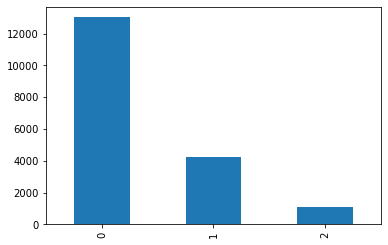

In [6]:
# Посмотрим на баланс классов в целевом признаке

data_train['TARGET'].value_counts().plot(kind='bar')


* В данных обучающей выборки представлено 18390 строк (объектов) и 262 столбца (260 признаков **FEATURE_0...FEATURE_259** с числовым типом данных `float64` и 2 с целочисленным `int64` - **ID** клиента и **TARGET** целевой признак с соответствующим клиенту сегментом)
* В данных имеются пропущенные значения по нескольким признакам
* Дубликатов в данных не обнаружено
* В данных присутствуют 4 признака, имеющие одинаковые значения по всем объектам
* В данных наблюдается дисбаланс классов: объектов класса 0 в три раза больше, чем объектов класса 1, и более чем в 10 раз больше, чем объектов класса 2.

<a href='#top'>Наверх</a>

<a id='section_2'></a>
## Предобработка данных
#### Заполнение пропусков

In [7]:
# Заполним пропущенные значения медианой по столбцу
# Так можно избежать влияния выбросов, присутствующих в выборке

data_test = data_test.apply(lambda x: x.fillna(x.median()))
data_train = data_train.apply(lambda x: x.fillna(x.median()))


In [8]:
# Проверим наличие пропусков после замены

print('_/_/_/ Пропущенные значения в тестовой выборке_/_/_/')
display(data_test.isna().sum().sort_values(ascending=False).head(3))
print('_/_/_/ Пропущенные значения в обучающей выборке _/_/_/')
display(data_train.isna().sum().sort_values(ascending=False).head(3))


_/_/_/ Пропущенные значения в тестовой выборке_/_/_/


FEATURE_259    0
FEATURE_95     0
FEATURE_93     0
dtype: int64

_/_/_/ Пропущенные значения в обучающей выборке _/_/_/


TARGET        0
FEATURE_96    0
FEATURE_94    0
dtype: int64

Пропуски в данных устранены

#### Проверка признаков на коллинеарность

In [9]:
# Выделим признаки в обучающей выборке
# Также исключим признаки, имеющие одинаковые значения по всем объектам

data_train_features = data_train.drop(columns={'ID', 'TARGET',
                                               'FEATURE_144', 'FEATURE_249',
                                               'FEATURE_256', 'FEATURE_3'})
data_train_features.columns


Index(['FEATURE_0', 'FEATURE_1', 'FEATURE_2', 'FEATURE_4', 'FEATURE_5',
       'FEATURE_6', 'FEATURE_7', 'FEATURE_8', 'FEATURE_9', 'FEATURE_10',
       ...
       'FEATURE_248', 'FEATURE_250', 'FEATURE_251', 'FEATURE_252',
       'FEATURE_253', 'FEATURE_254', 'FEATURE_255', 'FEATURE_257',
       'FEATURE_258', 'FEATURE_259'],
      dtype='object', length=256)

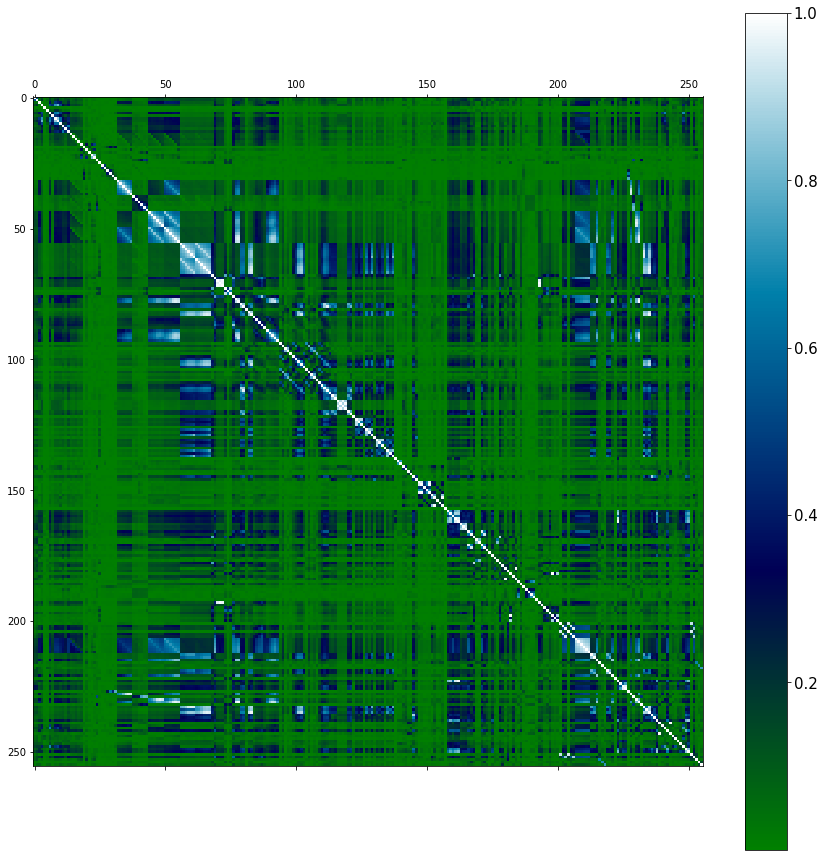

In [10]:
# Проверим признаки на коллинеарность

corr_train = data_train_features.corr().abs()

cmap = plt.get_cmap('ocean')
f = plt.figure(figsize=(15, 15))

plt.matshow(corr_train, cmap=cmap, fignum=f.number)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=15)


Как можно заметить некоторые признаки сильно коррелируют друг с другом, что может привести к переобучению модели. Часть признаков можно исключить из обучения. Будем считать значение корреляции `0.9`, как пороговое. Признаки, корреляция между которыми выше этого значения, оптимизируем.

In [11]:
# Выявим сильно коррелирующие друг с другом признаки

corr_train_threshold = 0.9
corr_train_features = set()

for i in range(len(corr_train.columns)):
    for j in range(i):
        if abs(corr_train.iloc[i, j]) > corr_train_threshold:
            col = corr_train.columns[i]
            corr_train_features.add(col)

len(corr_train_features)


44

44 признака, а это практически 17% данных, которые могут повлиять на то, что модель будет переобучена. Удалим эти признаки и оптимизируем выборку.

In [12]:
# Для удаления столбцов коррелирующих признаков воспользуемся функцией drop

data_train_features.drop(columns=corr_train_features, axis=1, inplace=True)
data_train_features.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18390 entries, 0 to 18389
Columns: 212 entries, FEATURE_0 to FEATURE_259
dtypes: float64(212)
memory usage: 29.7 MB


#### Разбиение на выборки

In [13]:
# Выделим признаки для обучения и целевой признак

X = data_train_features
y = data_train['TARGET']


In [14]:
# Разделим датасет на обучающую и валидационную выборки в соотношении 80:20

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,
                                                      random_state=rnd_state)

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)


(14712, 212)
(3678, 212)
(14712,)
(3678,)


### Выводы
* На этапе предобработки в данных обнаружились пропуски. Их обработка позволит провести анализ точнее. Поскольку сведения об объектах важно было сохранить для анализа, то мы не просто удалили все пропущенные значения, но заполнили пропущенные значения медианными. Теперь данные готовы для последующего анализа.
* Некоторые признаки сильно коррелировали друг с другом. Было взято значение корреляции между признаками 0.9, как пороговое. Признаки, корреляция между которыми выше этого значения, были удалены с целью оптимизации выборки. Всего 44 признака.
* Данные исходного датасета были разбиты на обучающую и валидационную подвыборки. Обучающая выборка используется для построения математических отношений между общими признаками и целевым признаком, а валидационная выборка служит для получения оценки прогнозных свойств модели на данных, не участвовавших в обучении.

<a href='#top'>Наверх</a>

<a id='section_3'></a>
## Исследование моделей
Исследуем качество разных моделей, меняя гиперпараметры. Для задачи многоклассовой классификации рассмотрим следующие:

* Дерево решений
* Случайный лес
* Логистическая регрессия
* CatBoost

#### Дерево решений

In [15]:
# Исследуем качество модели решающего дерева с различной глубиной

best_tree = None
best_score = 0

for max_depth in range(2, 12, 2):
    model = RandomForestClassifier(class_weight='balanced',
                                   max_depth=max_depth,
                                   random_state=rnd_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    result = f1_score(y_valid, y_pred, average='macro')

    if result > best_score:
        best_tree = model
        best_score = result

print('Качество лучшего дерева:', best_score)
print(best_tree)


Качество лучшего дерева: 0.4943543005370962
RandomForestClassifier(class_weight='balanced', max_depth=10,
                       random_state=260686)


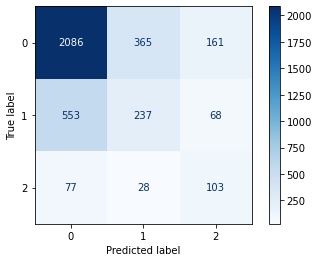

In [16]:
# Сопоставим предсказания и реальные данные с помощью матрицы ошибок

plot_confusion_matrix(best_tree, X_valid, y_valid, cmap=plt.cm.Blues)
plt.show()


In [17]:
print(classification_report(y_pred, y_valid))


              precision    recall  f1-score   support

           0       0.80      0.77      0.78      2716
           1       0.28      0.38      0.32       630
           2       0.50      0.31      0.38       332

    accuracy                           0.66      3678
   macro avg       0.52      0.48      0.49      3678
weighted avg       0.68      0.66      0.67      3678



Как можно заметить, метки класса 0 предсказываются с высокой точностью и полнотой. Что не скажешь о метках классов 1 и 2. Здесь необходимо смотреть детальнее, что может так влиять на качество предсказания именно в этих сегментах.

<a id='section_3_2'></a>
#### Случайный лес

In [18]:
# Исследуем качество модели случайного леса с подбором параметров

best_forest = None
best_score = 0

for estim in range(10, 51, 10):
    for max_depth in range(2, 12, 2):
        model = RandomForestClassifier(class_weight='balanced',
                                       n_estimators=estim,
                                       max_depth=max_depth,
                                       random_state=rnd_state)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        result = f1_score(y_valid, y_pred, average='macro')

        if result > best_score:
            best_forest = model
            best_score = result

print('Качество лучшего леса:', best_score)
print(best_forest)


Качество лучшего леса: 0.49005525538634226
RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50,
                       random_state=260686)


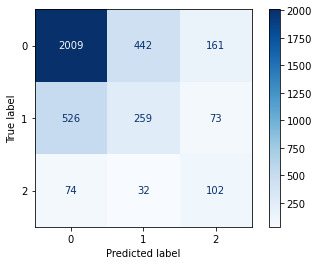

In [19]:
# Сопоставим предсказания и реальные данные с помощью матрицы ошибок

plot_confusion_matrix(best_forest, X_valid, y_valid, cmap=plt.cm.Blues)
plt.show()


In [20]:
print(classification_report(y_pred, y_valid))


              precision    recall  f1-score   support

           0       0.77      0.77      0.77      2609
           1       0.30      0.35      0.33       733
           2       0.49      0.30      0.37       336

    accuracy                           0.64      3678
   macro avg       0.52      0.48      0.49      3678
weighted avg       0.65      0.64      0.65      3678



В случае модели леса метки класса 0 предсказываются также с высокой точностью и полнотой. Стоит отметить и более высокую точность предсказания класса 2. Однако, класс 1 по прежнему предсказывается плохо.

<a id='section_3_3'></a>
#### Логистическая регрессия

In [21]:
# Check the F1-score for different solvers

best_logreg_model = None
best_score = 0
solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag']

for solver in solver_list:
    model = LogisticRegression(class_weight='balanced',
                               solver=solver,
                               random_state=rnd_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    result = f1_score(y_valid, y_pred, average='macro')

    if result > best_score:
        best_logreg_model = model
        best_score = result

print('Качество лучшей модели логистической регрессии:', best_score)
print(best_logreg_model)


Качество лучшей модели логистической регрессии: 0.45476606442416373
LogisticRegression(class_weight='balanced', random_state=260686,
                   solver='liblinear')


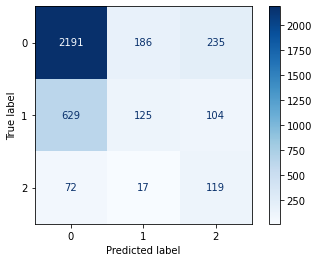

In [22]:
# Сопоставим предсказания и реальные данные с помощью матрицы ошибок

plot_confusion_matrix(best_logreg_model, X_valid, y_valid, cmap=plt.cm.Blues)
plt.show()


In [23]:
print(classification_report(y_pred, y_valid))


              precision    recall  f1-score   support

           0       0.45      0.77      0.57      1519
           1       0.37      0.28      0.32      1114
           2       0.72      0.14      0.24      1045

    accuracy                           0.44      3678
   macro avg       0.51      0.40      0.37      3678
weighted avg       0.50      0.44      0.40      3678



Логистическая регрессия лучше других моделей справилась с определением метки класса 0. Также как и модель случайного леса достаточно хорошо определила метки класса 2. Но при этом предсказание класса 1 показало наихудший результат.

In [24]:
# Проверим эффективность работы моделей с помощью кросс-валидации

cv_best_tree = np.average(cross_val_score(best_tree, X, y,
                          cv=5, scoring='f1_macro'))
cv_best_forest = np.average(cross_val_score(best_forest, X, y,
                            cv=5, scoring='f1_macro'))
cv_best_logreg_model = np.average(cross_val_score(best_logreg_model, X, y,
                                  cv=5, scoring='f1_macro'))

print('Среднее качество модели решающего дерева: ', cv_best_tree)
print('Среднее качество модели случайного леса: ', cv_best_forest)
print('Среднее качество модели логистической регрессии: ', cv_best_logreg_model)


Среднее качество модели решающего дерева:  0.5106467711224553
Среднее качество модели случайного леса:  0.5075517214236992
Среднее качество модели логистической регрессии:  0.46322758998559654


#### CatBoost

In [4]:
# вызовем CatBoost с нашими параметрами

model_cbc = CatBoostClassifier(
    iterations=100,
    random_seed=rnd_state,
    learning_rate=0.2)


In [3]:
%%time
start = time.time()
model_cbc.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    verbose=False,
    plot=True)
end = time.time()
catboost_time = end - start


NameError: name 'model_cbc' is not defined

In [27]:
start = time.time()
y_pred = model_cbc.predict(X_valid)
end = time.time()
catboost_time_predicting = end - start

print('Качество модели: ', f1_score(y_valid, y_pred, average='macro'))
print('Время обучения: ', catboost_time)
print('Время предсказания: ', catboost_time_predicting)


Качество модели:  0.43151184637973655
Время обучения:  4.741184234619141
Время предсказания:  0.009973764419555664


Text(0.5, 1.0, 'Значимость признаков для модели решающего дерева')

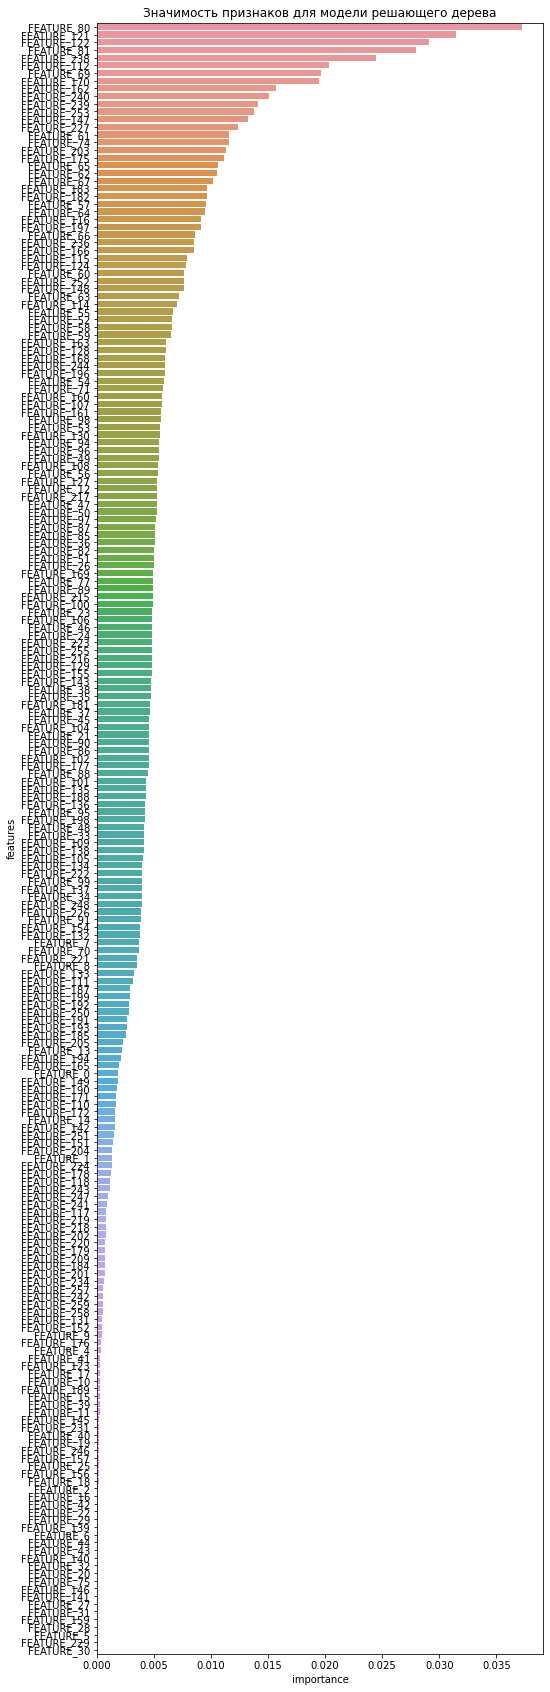

In [28]:
# Выведем график значимости признаков для лучшей модели

features = X_train.columns
importance = best_tree.feature_importances_

feature_importances = pd.DataFrame({'features': features,
                                    'importance': importance})
feature_importances = feature_importances.sort_values(by='importance',
                                                      ascending=False).\
                                                      reset_index(drop=True)

plt.figure(figsize=(8, 30))
sns.barplot(feature_importances['importance'], feature_importances['features'])

plt.title('Значимость признаков для модели решающего дерева')


Исследовав качество разных моделей со сменой гиперпараметров и применив для оценки метод кросс-валидации, выявили, что модель решающего дерева - оптимальна по качеству и скорости. Будем использовать данную модель для предсказаний на тестовой выборке.


Особое внимание обратим на Топ-5 признаков, обладающих наибольшей значимостью для модели.

Text(0.5, 0.98, 'Топ-5 признаков по степени значимости в модели')

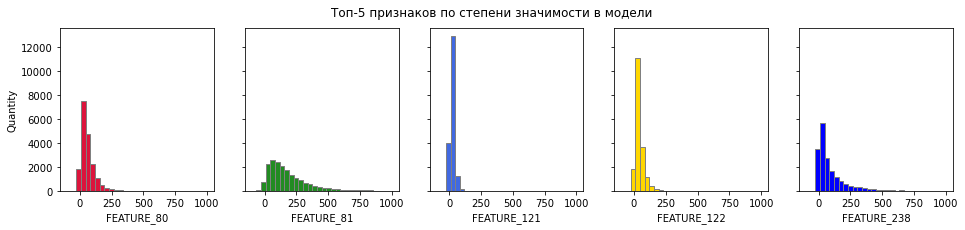

In [29]:
fig, axs = plt.subplots(1, 5, figsize=(16, 3), sharey=True)
axs[0].hist(data_train['FEATURE_80'], bins=30,
            range=(-100, 1000), color='crimson', ec='grey')
axs[1].hist(data_train['FEATURE_81'], bins=30,
            range=(-100, 1000), color='forestgreen', ec='grey')
axs[2].hist(data_train['FEATURE_121'], bins=30,
            range=(-100, 1000), color='royalblue', ec='grey')
axs[3].hist(data_train['FEATURE_122'], bins=30,
            range=(-100, 1000), color='gold', ec='grey')
axs[4].hist(data_train['FEATURE_238'], bins=30,
            range=(-100, 1000), color='blue', ec='grey')

axs[0].set_xlabel('FEATURE_80')
axs[1].set_xlabel('FEATURE_81')
axs[2].set_xlabel('FEATURE_121')
axs[3].set_xlabel('FEATURE_122')
axs[4].set_xlabel('FEATURE_238')
axs[0].set_ylabel("Quantity")

fig.suptitle("Топ-5 признаков по степени значимости в модели")


<a href='#top'>Наверх</a>

<a id='section_4'></a>
### Предсказания на тестовой выборке

In [30]:
# Запустим модель решающего дерева на тестовой выборке

data_test_features = data_train_features.columns
X = data_test[data_test_features]
y_pred = best_tree.predict(X)


In [31]:
# Сформируем искомый датасет из ID клиентов и предсказаний

data_test['TARGET'] = y_pred
contest_answer = data_test[['ID', 'TARGET']]


In [32]:
# Выгрузим данные полученных предсказаний

contest_answer.to_csv('contest_answer.csv', header=True, index=False)


<a href='#top'>Наверх</a>

<a id='section_5'></a>
## Заключение

* На этапе предобработки в данных обнаружились пропуски. Поскольку сведения об объектах важно было сохранить для анализа, то мы не просто удалили все пропущенные значения, но заполнили пропущенные значения медианными.
* Некоторые признаки сильно коррелировали друг с другом. Было взято значение корреляции между признаками 0.9, как пороговое. 44 признака, корреляция между которыми выше этого значения, были удалены с целью оптимизации выборки.
* Данные исходного датасета были разбиты на обучающую и валидационную подвыборки. Обучающая подвыборка используется для построения математических отношений между общими признаками и целевым признаком, а валидационная подвыборка служит для получения оценки прогнозных свойств модели на данных, не участвовавших в обучении.

* Для решения задачи многоклассовой классификации исследованы различные модели машинного обучения.
    * При использовании модели решающего дерева метки класса 0 предсказываются с высокой точностью и полнотой. Что не скажешь о метках классов 1 и 2. Здесь необходимо смотреть детальнее, что может так влиять на качество предсказания именно в этих сегментах.
    * В случае модели леса метки класса 0 предсказываются также с высокой точностью и полнотой. Стоит отметить и более высокую точность предсказания класса 2. Однако, класс 1 по прежнему предсказывается плохо.
    * Логистическая регрессия лучше других моделей справилась с определением метки класса 0. Также достаточно хорошо определила метки класса 2. Но при этом предсказание класса 1 показало наихудший результат.
    
* С применением метода кросс-валидации среди моделей с лучшими параметрами выявлены средние значения качества по целевой метрике (macro-f-score):
    * Дерево решений - 0.511
    * Случайный лес - 0.508
    * Логистическая регрессия - 0.463

* Дополнительно проверена модель, использующая алгоритм градиентного бустинга - CatBoost, показавшая результат по качеству модели - 0.432.

* В результате проведенного исследования выявлено, что по качеству и скорости оптимальна модель решающего дерева. 

* Выявлены Топ-5 признаков, обладающих наибольшей значимостью для модели - №80, 81, 121, 122 и 238.

* Модель решающего дерева использована для предсказаний на тестовой выборке.

<a href='#top'>Наверх</a>